# Model Notebook

This notebook contains the last of my work towards our final model.

In [432]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#.py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf

ImportError: cannot import name 'plot_confusion_matrix'

In [3]:
# import base dataframe
df = mcf.create_base_df()

In [4]:
long_index = df[df['longitude'] == 0].index

In [5]:
df = df.drop(long_index, axis=0)

In [6]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [7]:
df.shape

(57588, 20)

My group decided the rows with a longitude of 0 should be dropped. Now I can split the data and get right to modeling

In [8]:
# target
y = df['status_group']
# features
X = df.drop('status_group', axis=1)

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

I need to fill in the missing values for construction_year so I can calculate some sort of age column. I am going to continue doing it the way I have been, using the median construction_year for each basin. It may not be entirely accurate, but in the models I was creating it still was at the top of feature importance for the majority.

In [10]:
X_train['construction_year'] = X_train['construction_year'].replace(0, np.nan)

In [11]:
basins = X_train['basin'].unique()
med_year_basin = {}
for basin in basins:
    med_year = X_train[X_train['basin'] == basin].median()['construction_year']
    med_year_basin[basin] = med_year

In [12]:
X_train['construction_year'] = X_train['construction_year'].replace(np.nan, 0)

In [13]:
# fill in missing construction_year in X_train
for idx, row in X_train.iterrows():
    if row['construction_year'] == 0:
        X_train['construction_year'][idx] = med_year_basin[row['basin']]

# fill in missing construction_year in X_test
for idx, row in X_test.iterrows():
    if row['construction_year'] == 0:
        X_test['construction_year'][idx] = med_year_basin[row['basin']]

In [14]:
X_train['age'] = 2020 - X_train['construction_year']
X_test['age'] = 2020 - X_test['construction_year']

Now I can drop construction_year from both dataframes

In [15]:
X_train.drop('construction_year', axis=1, inplace=True)
X_test.drop('construction_year', axis=1, inplace=True)

In [16]:
df['construction_year'] = df['construction_year'].replace(0, np.nan)
df_med_year_basin = {}
for basin in basins:
    med_year = df[df['basin'] == basin].median()['construction_year']
    df_med_year_basin[basin] = med_year

df['construction_year'] = df['construction_year'].replace(np.nan)

# fill in missing construction_year in df
for idx, row in df.iterrows():
    if row['construction_year'] == 0:
        df['construction_year'][idx] = df_med_year_basin[row['basin']]

df['age'] = 2020 - df['construction_year']

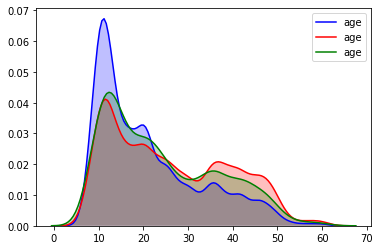

In [17]:
sns.kdeplot(df[df['status_group'] == 'functional']['age'], shade=True, color='blue')
sns.kdeplot(df[df['status_group'] == 'non functional']['age'], shade=True, color='red')
sns.kdeplot(df[df['status_group'] == 'functional needs repair']['age'], shade=True, color='green')


It's pretty clear that the age of the pump as a pretty significant affect on its functionality status. That may be a cool visual for the presentation. Time to get modeling.

### Features 1

In [18]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'installer', 'basin', 'region', 'lga',
       'population', 'extraction_type', 'extraction_type_group',
       'management_group', 'payment', 'water_quality', 'quality_group',
       'quantity', 'quantity_group', 'source_type', 'waterpoint_type',
       'waterpoint_type_group', 'age'],
      dtype='object')

In [19]:
cats = ['management_group', 'waterpoint_type_group', 'payment', 'extraction_type_group', 'source_type']
nums = ['amount_tsh', 'age', 'gps_height']
X_train1, X_test1 = mcf.process_data(X_train, X_test, cats, nums)

In [20]:
dt1 = DecisionTreeClassifier(max_depth=10, min_samples_split=3, max_features=.75)

In [21]:
dt1.fit(X_train1, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=0.75, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
print(classification_report(y_train, dt1.predict(X_train1)))

precision    recall  f1-score   support

             functional       0.68      0.90      0.77     25088
functional needs repair       0.58      0.06      0.11      3140
         non functional       0.75      0.53      0.62     17842

               accuracy                           0.70     46070
              macro avg       0.67      0.49      0.50     46070
           weighted avg       0.70      0.70      0.67     46070



In [23]:
feature_importance = pd.DataFrame(dt1.feature_importances_,
                                   index = X_train1.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [24]:
impute = SimpleImputer(strategy='most_frequent')
X_train['installer'] = impute.fit_transform(np.array(X_train['installer']).reshape(-1, 1))
X_train['installer_grouped'] = mcf.summarize_variable(X_train, 'installer', 10)

In [25]:
X_test['installer'] = impute.transform(np.array(X_test['installer']).reshape(-1, 1))
X_test['installer_grouped'] = mcf.summarize_variable(X_test, 'installer', 10)

In [26]:
X_train['lga_grouped'] = mcf.summarize_variable(X_train, 'lga', 16)
X_test['lga_grouped'] = mcf.summarize_variable(X_test, 'lga', 16)

In [27]:
feature_importance

,importance
x3_other,0.269033
age,0.193411
amount_tsh,0.131830
gps_height,0.104683
x4_borehole,0.043947
x1_other,0.034104
x3_mono,0.026136
x3_submersible,0.021289
x0_commercial,0.019546
x4_shallow well,0.017560


In [28]:
X_train['waterpoint_type_group'].value_counts()

communal standpipe    27476
hand pump             12935
other                  4957
improved spring         604
cattle trough            94
dam                       4
Name: waterpoint_type_group, dtype: int64

Waterpoint_type_group doesn't seem to be having much influence on the predictions. Half of it's categories are having no effect on the model so I am going to drop that column

In [29]:
cats = ['basin', 'quantity', 'source_type', 'installer_grouped']
nums = ['amount_tsh', 'age', 'gps_height']
X_train2, X_test2 = mcf.process_data(X_train, X_test, cats, nums)

In [30]:
X_train['management_group'].value_counts()

user-group    40594
commercial     2899
parastatal     1375
other           781
unknown         421
Name: management_group, dtype: int64

In [31]:
dt1.fit(X_train2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=0.75, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [32]:
print(classification_report(y_train, dt1.predict(X_train2)))

precision    recall  f1-score   support

             functional       0.69      0.92      0.79     25088
functional needs repair       0.61      0.12      0.19      3140
         non functional       0.81      0.55      0.66     17842

               accuracy                           0.72     46070
              macro avg       0.70      0.53      0.55     46070
           weighted avg       0.73      0.72      0.70     46070



In [33]:
dt1.score(X_train2, y_train)

0.7224441067940092

About .7 accuracy, not bad. I want to check feature importance again and see what I can add/drop

In [34]:
feature_importance = pd.DataFrame(dt1.feature_importances_,
                                   index = X_train2.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [35]:
feature_importance

,importance
x1_dry,0.264341
x1_enough,0.174877
age,0.137747
amount_tsh,0.096806
gps_height,0.096074
x2_borehole,0.024087
x0_Lake Tanganyika,0.020882
x3_Government,0.019086
x0_Lake Nyasa,0.017139
x2_spring,0.014938


Those are the features I am going to use for now. I need to experiment with some different models.

In [36]:
# rf1 = RandomForestClassifier(n_estimators=1000)

In [37]:
rf1.fit(X_train2, y_train)

NameError: name 'rf1' is not defined

In [38]:
print(classification_report(y_train, rf1.predict(X_train2)))

NameError: name 'rf1' is not defined

In [39]:
recall_score(y_train, rf1.predict(X_train2), average='weighted')

NameError: name 'rf1' is not defined

In [40]:
recall_score(y_test, rf1.predict(X_test2), average='weighted')

NameError: name 'rf1' is not defined

Not bad, training recall of about .9. I want to try XGBoost now

In [41]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'installer', 'basin', 'region', 'lga',
       'population', 'extraction_type', 'extraction_type_group',
       'management_group', 'payment', 'water_quality', 'quality_group',
       'quantity', 'quantity_group', 'source_type', 'waterpoint_type',
       'waterpoint_type_group', 'age', 'installer_grouped', 'lga_grouped'],
      dtype='object')

In [42]:
X_test['lga_grouped'].value_counts()

lga_other        8114
Njombe            511
Arusha Rural      260
Moshi Rural       259
Kilosa            236
Kasulu            233
Rungwe            216
Kilombero         207
Mbozi             200
Bagamoyo          193
Meru              186
Kibondo           185
Singida Rural     183
Same              179
Maswa             179
Kigoma Rural      177
Name: lga_grouped, dtype: int64

In [43]:
X_train['lga_grouped'].value_counts()

lga_other        32755
Njombe            1992
Arusha Rural       992
Moshi Rural        992
Rungwe             890
Kilosa             858
Mbozi              834
Meru               823
Kasulu             814
Singida Rural      812
Bagamoyo           804
Kilombero          752
Kyela              698
Same               698
Kibondo            689
Kahama             667
Name: lga_grouped, dtype: int64

In [44]:
X_train['lga_grouped'] = mcf.summarize_variable(X_train, 'lga', 12)
X_test['lga_grouped'] = mcf.summarize_variable(X_test, 'lga', 11)

In [45]:
'lga','quantity_group','quality_group','management_group','extraction_type','source_type','waterpoint_type'

('lga',
 'quantity_group',
 'quality_group',
 'management_group',
 'extraction_type',
 'source_type',
 'waterpoint_type')

In [359]:
cats = ['management_group', 'quantity', 'source_type', 'waterpoint_type', 'extraction_type', 'quality_group']
nums = ['gps_height', 'amount_tsh', 'population']
X_train3, X_test3 = mcf.process_data(X_train, X_test, cats, nums)

In [360]:
xgb1 = XGBClassifier(random_state=42, objective = 'multi:softmax',
                      num_class = 3, learning_rate=.25, 
                      max_delta_step=10, reg_alpha=2, reg_lambda=0, n_estimators=100)
# scale_pos_weight

In [361]:
xgb1.fit(X_train3, y_train)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_train, xgb1.predict(X_train3)))
print(classification_report(y_test, xgb1.predict(X_test3)))

In [ ]:
accuracy_score(y_train, xgb1.predict(X_train3))

In [73]:
accuracy_score(y_test, xgb1.predict(X_test3),)

0.7726167737454419

In [443]:
cat_vars2 = ['lga','quantity','management_group', 'source_type', 'extraction_type', 'waterpoint_type', 'payment']
num_vars2 = ['amount_tsh']
X_train4, X_test4 = mcf.process_data(X_train, X_test, cat_vars2, num_vars2)

In [444]:
rf2 = RandomForestClassifier(n_estimators=100, random_state=42, max_features='auto')

In [448]:
X_train4.drop('amount_tsh', axis=1, inplace=True)
X_test4.drop('amount_tsh', axis=1, inplace=True)

In [449]:
rf2.fit(X_train4, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [450]:
print(classification_report(y_train, rf2.predict(X_train4)))

precision    recall  f1-score   support

             functional       0.80      0.92      0.86     25088
functional needs repair       0.66      0.32      0.43      3140
         non functional       0.86      0.77      0.81     17842

               accuracy                           0.82     46070
              macro avg       0.78      0.67      0.70     46070
           weighted avg       0.82      0.82      0.81     46070



In [451]:
print(classification_report(y_test, rf2.predict(X_test4)))

precision    recall  f1-score   support

             functional       0.77      0.89      0.82      6301
functional needs repair       0.51      0.22      0.31       791
         non functional       0.81      0.71      0.76      4426

               accuracy                           0.77     11518
              macro avg       0.69      0.61      0.63     11518
           weighted avg       0.77      0.77      0.76     11518



In [441]:
cm = mcf.plot_confusion_matrix(y_test, rf2.predict(X_test4))

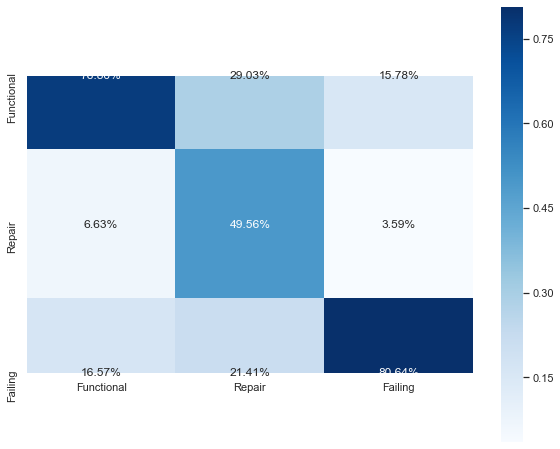

In [442]:
sns.set(font_scale=1)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues', square=True)

In [452]:
feature_importance = pd.DataFrame(rf2.feature_importances_,
                                   index = X_train4.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [483]:
feature_importance[:10]

,importance
x1_dry,0.129615
x1_enough,0.054982
x4_other,0.049384
x5_other,0.047129
x6_never pay,0.028252
x1_insufficient,0.026307
x5_communal standpipe,0.023051
x5_hand pump,0.019907
x4_gravity,0.018036
x6_pay per bucket,0.016358


In [482]:
df['source_type'].value_counts()

spring                  17006
shallow well            15499
borehole                11699
river/lake              10251
rainwater harvesting     2218
dam                       649
other                     266
Name: source_type, dtype: int64

In [454]:
X_train['quantity_group'].value_counts()

enough          25821
insufficient    11616
dry              4808
seasonal         3206
unknown           619
Name: quantity_group, dtype: int64

In [456]:
wq_types = df['quantity_group'].unique()
wq_b_bar = {}
wq_m_bar = {}
wq_t_bar = {}

for wq in wq_types:
    tot_observs = len(df[df['quantity_group'] == wq])
    func = len(df[(df['quantity_group'] == wq) & (df['status_group'] == 'functional')])
    fail = len(df[(df['quantity_group'] == wq) & (df['status_group'] == 'non functional')])
    repair = len(df[(df['quantity_group'] == wq) & (df['status_group'] == 'functional needs repair')])
    wq_b_bar[wq] = 100
    wq_m_bar[wq] = round(((fail+func)/tot_observs)*100, 0)
    wq_t_bar[wq] = round((func/tot_observs)*100, 0)

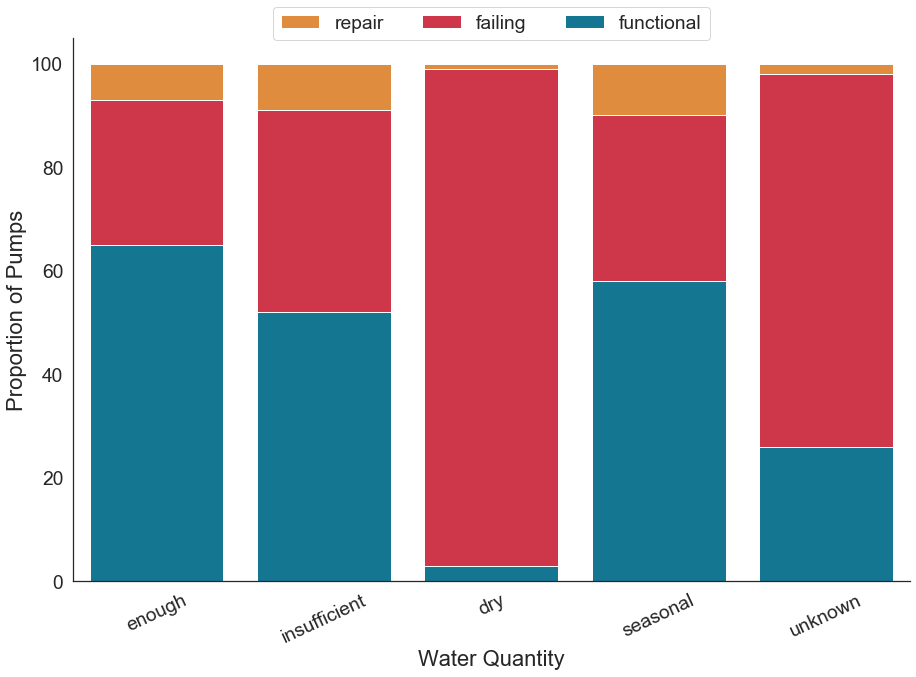

In [458]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")

x = list(wq_b_bar.keys())
y1 = list(wq_b_bar.values())
y2 = list(wq_m_bar.values())
y3 = list(wq_t_bar.values())

bottom_bar = sns.barplot(x=x, y=y1, color='#fb8b24', label='repair')
middle_bar = sns.barplot(x=x, y=y2, color='#e71d36', label='failing')
top_bar = sns.barplot(x=x, y=y3, color='#0081a7', label='functional')

bottom_bar.set_xlabel('Water Quantity', fontsize=22)
bottom_bar.set_ylabel('Proportion of Pumps', fontsize=22)
bottom_bar.set_xticklabels(x, rotation=25)

sns.despine(top=True, right=True)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.075), ncol=3)

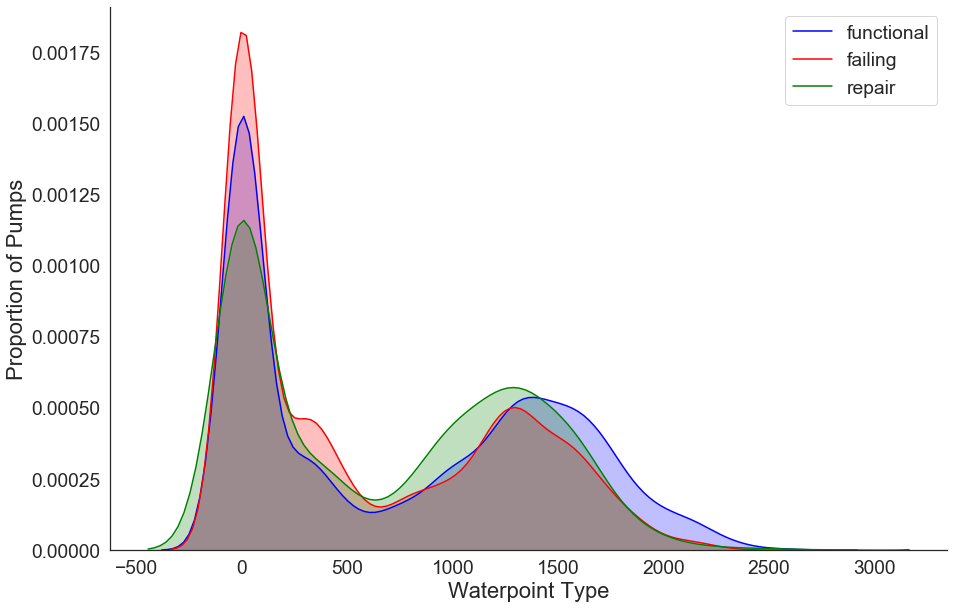

In [427]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")
splot1 = sns.kdeplot(df[df['status_group'] == 'functional']['gps_height'], shade=True, color='blue', label='functional', )
sns.kdeplot(df[df['status_group'] == 'non functional']['gps_height'], shade=True, color='red', label='failing')
sns.kdeplot(df[df['status_group'] == 'functional needs repair']['gps_height'], shade=True, color='green', label='repair')

splot1.set_xlabel('Waterpoint Type', fontsize=22)
splot1.set_ylabel('Proportion of Pumps', fontsize=22)

sns.despine(top=True, right=True)

In [353]:
df['construction_year'] = df['construction_year'].replace(0, np.nan)

Text(0, 0.5, 'Proportion of Pumps')

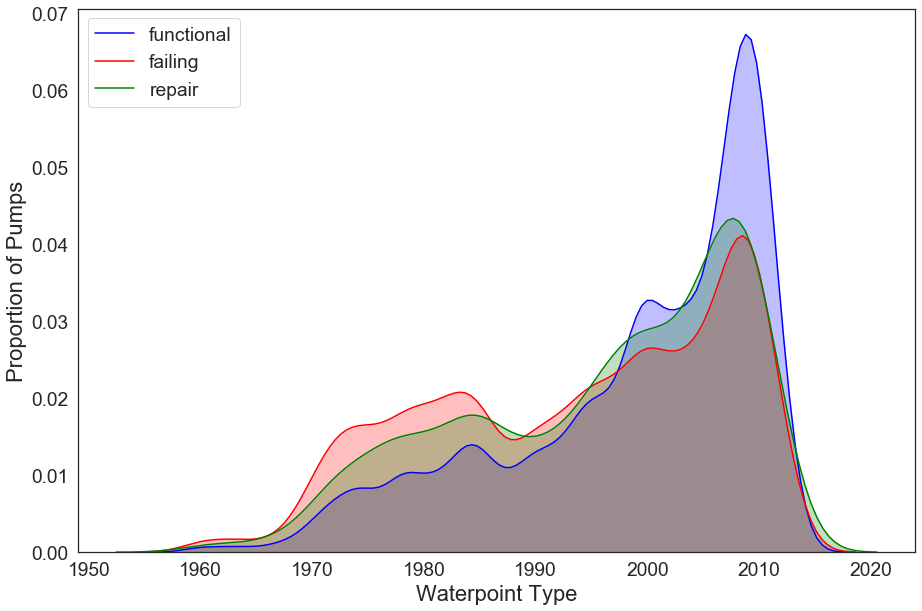

In [354]:
sns.set_context({"figure.figsize": (15, 10)})
sns.set(font_scale=1.75)
sns.set_style("white")
splot1 = sns.kdeplot(df[df['status_group'] == 'functional']['construction_year'], shade=True, color='blue', label='functional', )
sns.kdeplot(df[df['status_group'] == 'non functional']['construction_year'], shade=True, color='red', label='failing')
sns.kdeplot(df[df['status_group'] == 'functional needs repair']['construction_year'], shade=True, color='green', label='repair')

splot1.set_xlabel('Waterpoint Type', fontsize=22)
splot1.set_ylabel('Proportion of Pumps', fontsize=22)

,spring,rainwater harvesting,dam,borehole,other,shallow well,river/lake
functional,10581,1336,253,5778,158,7683,5600
failing,5150,587,372,5426,103,7212,3418
repair,1275,295,24,495,5,604,1233


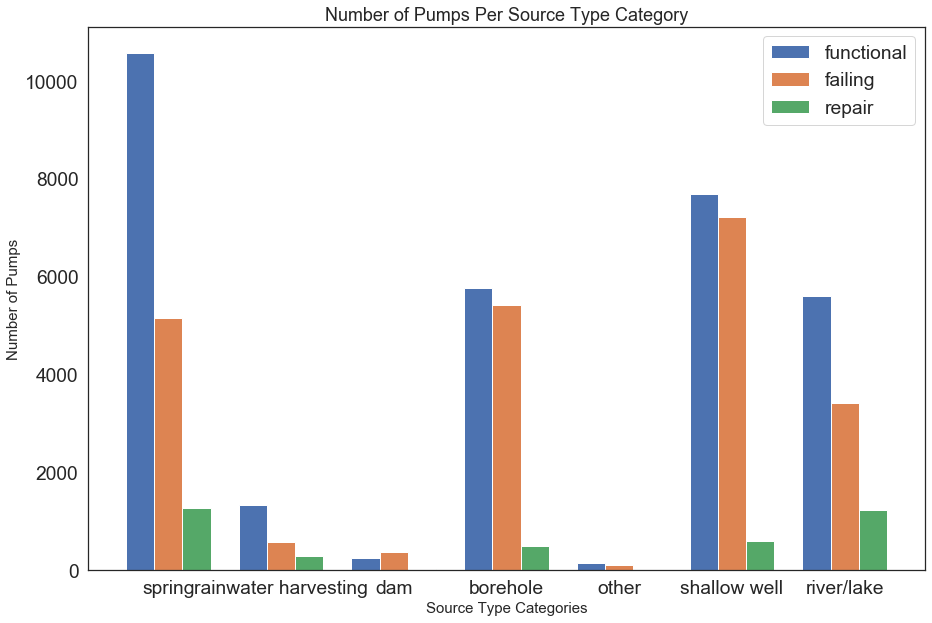

In [475]:
mcf.plot_category(df, 'source_type')

In [478]:
df.groupby(['source_type', 'quantity'])['status_group'].count()

source_type           quantity    
borehole              dry              1435
                      enough           7175
                      insufficient     2524
                      seasonal          283
                      unknown           282
dam                   dry                59
                      enough            372
                      insufficient      179
                      seasonal           30
                      unknown             9
other                 dry                32
                      enough            127
                      insufficient       68
                      seasonal           12
                      unknown            27
rainwater harvesting  dry               150
                      enough            294
                      insufficient      602
                      seasonal         1148
                      unknown            24
river/lake            dry               803
                      enough           61